# What is autograd? - Finding the minimum of a function with PyTorch

In recent years, there has been a marked increase in media and academic attention towards advancements in artificial intelligence, particularly concerning deep neural networks. The most pronounced surge in attention was observed following the release of ChatGPT last November. Although the usage of these tools is rooted in controversies (*e.g.* [1](https://www.newyorker.com/culture/infinite-scroll/is-ai-art-stealing-from-artists), [2](https://www.aclu.org/news/privacy-technology/how-artificial-intelligence-can-deepen-racial-and-economic-inequities), [3](https://www.forbes.com/sites/mattnovak/2023/05/27/lawyer-uses-chatgpt-in-federal-court-and-it-goes-horribly-wrong) ), it led to a similar spike in the interest for computational resources that facilitate the implementation of neural networks, such as the Python libraries [PyTorch](https://pytorch.org/) and [TensorFlow](https://www.tensorflow.org/). Nonetheless, I posit that the interest in neural networks may overshadow what I consider the pinnacle achievement of these libraries: the automatic differentiation technique known as autograd.

In what follows, I will give a brief example of using autograd with an explanation of what it does in calculus terms and use autograd to implement one of the most useful optimization methods (methods to find the maximum or minumim of a function) the [gradient descent algorithm](https://en.wikipedia.org/wiki/Gradient_descent) in no more than 5 lines of code.

## Automatically calculating a gradient

First, let us study an example of a multivariate function. For notational simplicity let $\mathbf{a}$ be a three dimensional vector $\mathbf{a} = [x,y,z]$ and define the function 
$$f(\mathbf{a}) = f(x,y,z) = x^2 + 2y^2 + 3z^2 - 2xy + 2xz - 4yz + 2x - 2y + 2 \ ,$$

which we shall write in Python as

In [1]:
import torch

def function(a):
    x,y,z = a
    return x**2 + 2*y**2 + 3*z**2 - 2*x*y + 2*x*z -4*y*z +2*x -2*y +2

We can define the gradient $\nabla f(\mathbf{a})$ of such function as 
$$
\begin{equation}
\nabla f(\mathbf{a}) = \left[
\frac{\partial{f}}{\partial x} \ ,
\frac{\partial{f}}{\partial y} \ ,
\frac{\partial{f}}{\partial z} \right] \ .
\end{equation}
$$
In broad terms, the gradient of a function is a vector that points in the direction of the steepest ascent of such function, meaning it points towards the direction, from $\mathbf{a}$, where the function would increase the most for a infinitesimally small jump.  Conversely, moving against the gradient would take you in the direction of the steepest descent, or where the function decreases the most rapidly.

For our function $f$ defined above, the gradient can be calculated through the usual methods of calculus as
$$
\begin{equation}
\nabla f(\mathbf{a}) =  \left[
2x - 2y + 2z + 2 \ ,
4y - 2x - 4z - 2 \ ,
6z + 2x - 4y \right] \ ,
\end{equation}
$$
and implemented in Python (PyTorch) as

In [2]:
def gradient(a):
    x,y,z = a
    df_dx = 2*x - 2*y + 2*z + 2
    df_dy = 4*y - 2*x - 4*z - 2
    df_dz = 6*z + 2*x - 4*y
    return torch.tensor((df_dx, df_dy, df_dz))

Let us see it working on a simple example, by calculating the gradient at the coordinate origin $\mathbf{a} = [0,0,0]$

In [3]:
a = torch.zeros(3,requires_grad=True) 
gradient(a)

tensor([ 2., -2.,  0.])

For more intricate functions, or when dealing with a high number of variables, manually computing each derivative and crafting a Python function to determine the gradient can become extremely laborious. In such scenarios, an automated tool like autograd proves to be considerably more convenient. To illustrate, using the previously defined function, we can demonstrate as follows:

1 - First we calculate the function at the point we ought to take the gradient

In [4]:
a = torch.zeros(3,requires_grad=True) 
y = function(a)

To implement autograd, it is fundamental that the original variable $\mathbf{a}$ were created with `requires_grad=True`.

2 - Then, we perform what is know as backward pass, in PyTorch that means using the `backward` method

In [5]:
y.backward()

3 - From this, the gradient is directly calculated using the `grad` method into the original variable

In [6]:
a.grad

tensor([ 2., -2.,  0.])

matching the directly calculated result. For a good understanding of what happens ``under the hood'' I refer to [this lecture](https://www.youtube.com/watch?v=VMj-3S1tku0) by [Andrej Karpathy](https://www.youtube.com/@AndrejKarpathy).


Before moving to an explanation of how to use `autograd` for finding minima, let us see how the two methods give rise to the same gradients for random values of $\mathbf{a}$:

In [7]:
for i in range(6):
    a = torch.rand(3,requires_grad=True)
    y = function(a)
    y.backward()
    print('autograd:            {}     \ndirectly calculated: {} \n'.format(a.grad,gradient(a)))

autograd:            tensor([ 3.5486, -4.2497,  4.1119])     
directly calculated: tensor([ 3.5486, -4.2497,  4.1119]) 

autograd:            tensor([ 3.1461, -3.2958,  3.2110])     
directly calculated: tensor([ 3.1461, -3.2958,  3.2110]) 

autograd:            tensor([ 1.7504, -0.0786, -1.7575])     
directly calculated: tensor([ 1.7504, -0.0786, -1.7575]) 

autograd:            tensor([ 3.2295, -3.1460,  2.3714])     
directly calculated: tensor([ 3.2295, -3.1460,  2.3714]) 

autograd:            tensor([ 2.8821, -3.4228,  2.6882])     
directly calculated: tensor([ 2.8821, -3.4228,  2.6882]) 

autograd:            tensor([ 2.6509, -1.7598,  0.5604])     
directly calculated: tensor([ 2.6509, -1.7598,  0.5604]) 



## The gradient descent method

As previously mentioned, the gradient indicates the direction of steepest ascent and opositive to the steepest descent. Intuitively, we can envision a method to find the minimum of a function by:
1. evaluating the gradient.
2. taking a small step in the negative gradient direction.

This process is repeated until we find a point where all components of the gradient are zero. Because you are consistently moving towards the steepest descent, this would indicate a point of minima. In mathematical terms, we can express a move from a point $\mathbf{a}_i$ to $\mathbf{a}_{i+1}$ as
$$ \mathbf{a}_{i+1} = \mathbf{a}_i - \eta \nabla f(\mathbf{a}) \ ,$$
where $\eta$ is the relative step size which, in the deep learning community, is also referred to as the learning rate. If $\mathbf{a}$ is not a minima or a maximum, it is mathematically guaranteed that there exists a sufficiently small positive value of $\eta$ that implies $f(\mathbf{a}_{i+1}) < f(\mathbf{a}_i)$.

To demonstrate this in practice, let us find the minimum of the function $f$ described earlier. Using standard calculus, we determine that there is a minimum as $\mathbf{a}_\text{max} = [-1,1,1]$ with $f(\mathbf{a}_\text{max})=0$. Let us try to find that using gradient descent, such a task is straighforward in PyTorch, let us fist decide on an initial point $\mathbf{a}_0$ and a learning rate $\eta$ as

In [8]:
a=torch.zeros(3,requires_grad=True)
learning_rate =.01

Now, let us use it by finding the final state after 1000 interactions of the algorithm, this is easily done in PyTorch as

In [9]:
for i in range(1000):
    y = function(a).backward()
    with torch.no_grad():
        a += -learning_rate * a.grad # Update x in the direction of the gradient
        a.grad.zero_()

The final value of $\mathbf{a}$ from this loop is 

In [10]:
a

tensor([-1.0006,  0.9993,  0.9997], requires_grad=True)

which is close to the known maxima $\mathbf{a}_\text{max} = [-1,1,1]$, but it doesn't match with full mathematical precision. This indicates that a mere 1000 steps was not sufficient to pinpoint the minima with the accuracy inherent to floating-point precision.

This observation shows the need for a mathematical criterion to determine an appropriate stopping point. Given that a minima implies that all components of the gradient converge to zero, a practical approach would be to continue iterations until the absolute values of all gradient components fall below a specified "tolerance" value. This can be implemented as follows:

In [11]:
tol = 1e-5 #tolerance value
a=torch.zeros(3,requires_grad=True) #reseting initial

stop = False
while not stop:
    y = function(a).backward()
    stop = torch.max(torch.abs(a.grad))<tol
    with torch.no_grad():
        a += -learning_rate * a.grad # Update a in the direction of the gradient
        a.grad.zero_()
a_min = a

Thus leading to the correct value

In [12]:
a

tensor([-1.0000,  1.0000,  1.0000], requires_grad=True)

To encapsulate the trajectory pursued by gradient descent, the subsequent graph maps its path in a 3D space. This visualization brings to light the intricate journey a model undertakes to reach its optimal state. Beginning with an initial guess, every ensuing step—marked distinctly by a point—depicts the model's progressive descent towards the function's minima. In the graph, the color of these points transforms from purple, indicative of the initial steps, to yellow as the descent progresses.

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

tol = 1e-5 #tolerance value
a=torch.zeros(3,requires_grad=True) #reseting initial

a_all =[]
for i in range(250):
    y = function(a).backward()
    with torch.no_grad():
        a += -learning_rate * a.grad # Update a in the direction of the gradient
        a.grad.zero_()
    a_all.append(a*1)
a_all = torch.stack(a_all).detach().numpy()

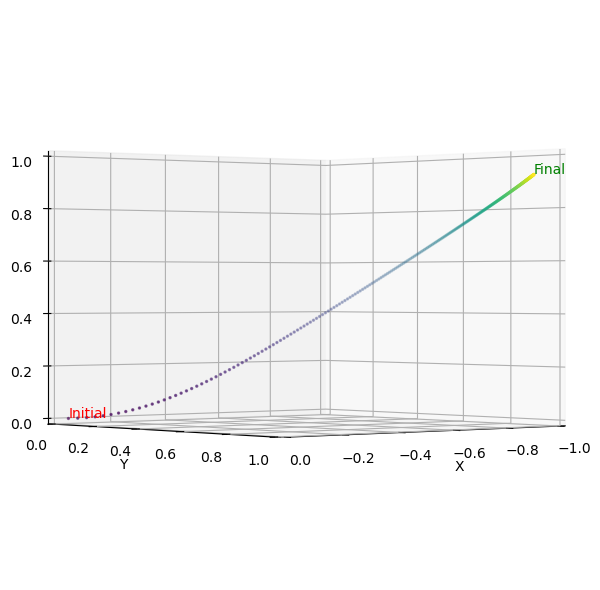

In [14]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

ax.scatter3D(a_all[:,0], a_all[:,1], a_all[:,2], c=range(len(a_all)),s=2)
ax.text(*a_all[0], "Initial", color='red')
ax.text(*a_all[-1], "Final", color='green')
ax.view_init(0, 50)
ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')
ax.set_xlim((-1,0)), ax.set_ylim((0,1)), ax.set_zlim((0,1))
fig.tight_layout()
plt.show()

## Conclusion

Autograd is a fundamental feature in PyTorch, equipping the framework with the capability to automatically compute derivatives for a myriad of operations, including those that span multiple layers and functions. By eliminating the complexities of manual differentiation for developers, Autograd simplifies the implementation of gradient descent. At its core, it's this very principle of gradient descent that drives the training of neural networks. The discussion presented here centered on how gradient descent finds the minima of a function. Typically, however, PyTorch users lean on the `optim` [package](https://pytorch.org/docs/stable/optim.html) that gradient descent and other optimization algorithms already implemented, however a survey of those will be left for a future blog post.

Text(0.5, 0.98, 'Visualizing gradient descent')

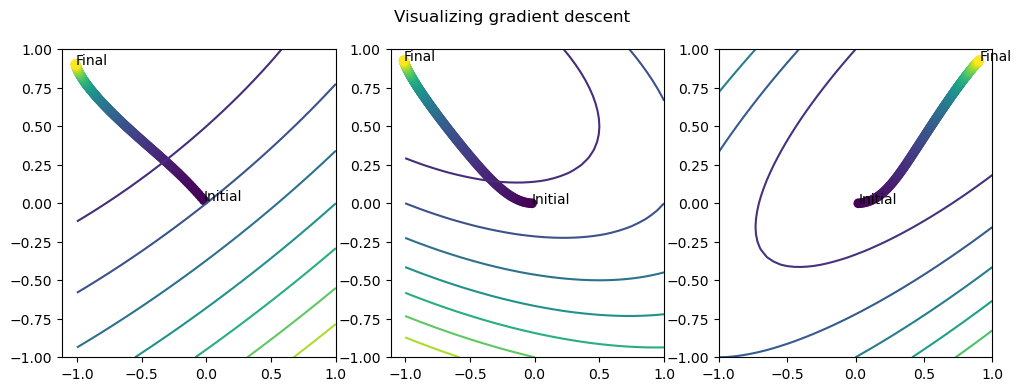

In [26]:
import numpy as np
fig,axs= plt.subplots(1,3,figsize=(12,4))

for (ax,inds) in zip(axs,[[0,1],[0,2],[1,2]]):
    a_inds = a_all[:,inds]
    ax.scatter(*a_inds.T,c=range(len(a_inds)))
    ax.text(*a_inds[0], "Initial", color='k')
    ax.text(*a_inds[-1], "Final", color='k')

    X,Y = np.meshgrid(np.linspace(-1,1,41),
                       np.linspace(-1,1,41))
    err = [X,Y]
    l = [err.pop(0) if i in inds else a_min[i].detach().numpy() for i in range(3)]
    ax.contour(X,Y,function(l))

fig.suptitle('Visualizing gradient descent')

In [22]:
l

[array(-1.0000108, dtype=float32),
 array([[-1.  , -0.95, -0.9 , ...,  0.9 ,  0.95,  1.  ],
        [-1.  , -0.95, -0.9 , ...,  0.9 ,  0.95,  1.  ],
        [-1.  , -0.95, -0.9 , ...,  0.9 ,  0.95,  1.  ],
        ...,
        [-1.  , -0.95, -0.9 , ...,  0.9 ,  0.95,  1.  ],
        [-1.  , -0.95, -0.9 , ...,  0.9 ,  0.95,  1.  ],
        [-1.  , -0.95, -0.9 , ...,  0.9 ,  0.95,  1.  ]]),
 array([[-1.  , -1.  , -1.  , ..., -1.  , -1.  , -1.  ],
        [-0.95, -0.95, -0.95, ..., -0.95, -0.95, -0.95],
        [-0.9 , -0.9 , -0.9 , ..., -0.9 , -0.9 , -0.9 ],
        ...,
        [ 0.9 ,  0.9 ,  0.9 , ...,  0.9 ,  0.9 ,  0.9 ],
        [ 0.95,  0.95,  0.95, ...,  0.95,  0.95,  0.95],
        [ 1.  ,  1.  ,  1.  , ...,  1.  ,  1.  ,  1.  ]])]

In [23]:
function(l)

array([[4.00000000e+00, 4.00500108e+00, 4.02000217e+00, ...,
        1.12200412e+01, 1.16050423e+01, 1.20000434e+01],
       [3.80749892e+00, 3.80250000e+00, 3.80750108e+00, ...,
        1.06475401e+01, 1.10225412e+01, 1.14075423e+01],
       [3.62999783e+00, 3.61499892e+00, 3.61000000e+00, ...,
        1.00900391e+01, 1.04550401e+01, 1.08300412e+01],
       ...,
       [7.22995878e+00, 6.85495986e+00, 6.48996095e+00, ...,
        1.00000000e-02, 1.50010848e-02, 3.00021696e-02],
       [7.60745769e+00, 7.22245878e+00, 6.84745986e+00, ...,
        7.49891520e-03, 2.50000000e-03, 7.50108480e-03],
       [7.99995661e+00, 7.60495769e+00, 7.21995878e+00, ...,
        1.99978304e-02, 4.99891520e-03, 0.00000000e+00]])

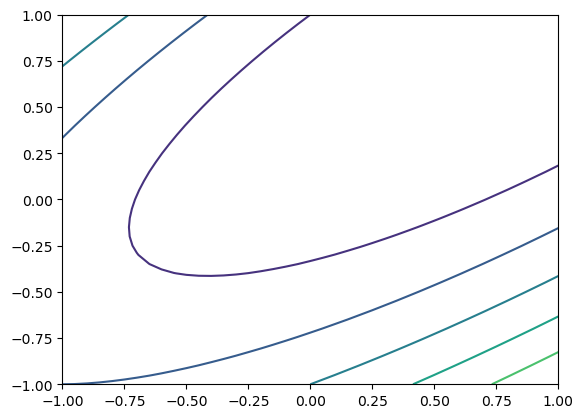

In [25]:
plt.contour(X,Y,function(l))

In [29]:
X,Y = np.meshgrid(np.linspace(-1,1,41),
                  np.linspace(-1,1,41))
Z = X*1.0